In [1]:
# Project Update 3: AI-Assisted VIA for Cervical Cancer Screening
# Preliminary Model Training Progress Report

# import package
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from tqdm import tqdm
import os

print("Project: AI-Assisted Visual Inspection with Acetic acid (VIA) for Cervical Cancer Screening")
print("Date:", datetime.now().strftime("%Y-%m-%d"))
print("=" * 80)

Project: AI-Assisted Visual Inspection with Acetic acid (VIA) for Cervical Cancer Screening
Date: 2025-11-29


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change to your data path
DataPath = "/content/drive/MyDrive"

print(f"Data path: {DataPath}")
print("Checking directory structure...")

# Check if dataset_split exists
if os.path.exists(os.path.join(DataPath, 'dataset_split')):
    print("✓ dataset_split folder found")
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(DataPath, 'dataset_split', split)
        if os.path.exists(split_path):
            print(f"  ✓ {split} folder found")
            for class_name in ['negative', 'positive', 'suspiciousCancer']:
                class_path = os.path.join(split_path, class_name)
                if os.path.exists(class_path):
                    num_images = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
                    print(f"    - {class_name}: {num_images} images")
else:
    print("✗ dataset_split folder not found!")

Mounted at /content/drive
Data path: /content/drive/MyDrive
Checking directory structure...
✓ dataset_split folder found
  ✓ train folder found
    - negative: 104 images
    - positive: 89 images
    - suspiciousCancer: 18 images
  ✓ val folder found
    - negative: 22 images
    - positive: 19 images
    - suspiciousCancer: 4 images
  ✓ test folder found
    - negative: 22 images
    - positive: 19 images
    - suspiciousCancer: 4 images


In [3]:
"""
VIA+IARC: train/val/test=70:15:15
dimension: 800*640
{'negative': 0, 'positive': 1, 'suspiciousCancer': 2}
"""

# IMPROVED: Slightly stronger augmentation (careful not to overdo)
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(18),  # 15→18: slightly more rotation
    transforms.ColorJitter(brightness=0.35, contrast=0.35, saturation=0.25, hue=0.02),  # Slightly stronger
    transforms.RandomResizedCrop((224, 224), scale=(0.82, 1.0)),  # 0.85→0.82: slightly more aggressive
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.08))  # ADD: Cutout for regularization
])

val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_ds = datasets.ImageFolder(DataPath + '/dataset_split/train', transform=train_transform)
val_ds   = datasets.ImageFolder(DataPath + '/dataset_split/val',   transform=val_test_transform)
test_ds  = datasets.ImageFolder(DataPath + '/dataset_split/test',  transform=val_test_transform)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

print(f"Class mapping: {train_ds.class_to_idx}")
print(f"Train: {len(train_ds)} images, Val: {len(val_ds)} images, Test: {len(test_ds)} images")

# Calculate class weights for imbalanced dataset
from collections import Counter
class_counts = Counter([train_ds[i][1] for i in range(len(train_ds))])
total_samples = sum(class_counts.values())
class_weights = torch.tensor([total_samples / (len(class_counts) * class_counts[i])
                               for i in range(len(class_counts))], dtype=torch.float)
print(f"Class distribution: {class_counts}")
print(f"Class weights: {class_weights}")

Class mapping: {'negative': 0, 'positive': 1, 'suspiciousCancer': 2}
Train: 211 images, Val: 45 images, Test: 45 images
Class distribution: Counter({0: 104, 1: 89, 2: 18})
Class weights: tensor([0.6763, 0.7903, 3.9074])


Sample training images:


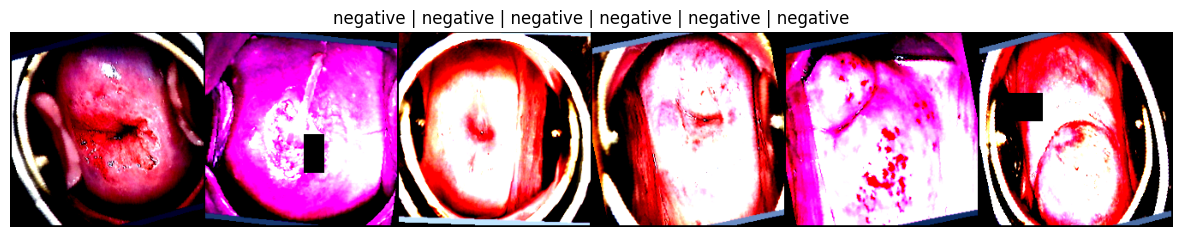


Batch shape: torch.Size([16, 3, 224, 224])
Labels in batch: tensor([0, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 0, 0, 0, 0, 1])


In [4]:
def show_images(dataset, n=6):
    """Display n images from the dataset"""
    imgs = [dataset[i][0] for i in range(min(n, len(dataset)))]
    labels = [dataset.classes[dataset[i][1]] for i in range(min(n, len(dataset)))]
    grid = make_grid(imgs, nrow=n)
    plt.figure(figsize=(15, 3))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis('off')
    plt.title(" | ".join(labels))
    plt.show()

# Show sample images from training set
print("Sample training images:")
show_images(train_ds, n=6)

# Check batch shape
images, labels = next(iter(train_loader))
print(f"\nBatch shape: {images.shape}")
print(f"Labels in batch: {labels}")

/tmp/ipython-input-2996545160.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(classes, rotation=45)
/tmp/ipython-input-2996545160.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(classes, rotation=45)
/tmp/ipython-input-2996545160.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(classes, rotation=45)


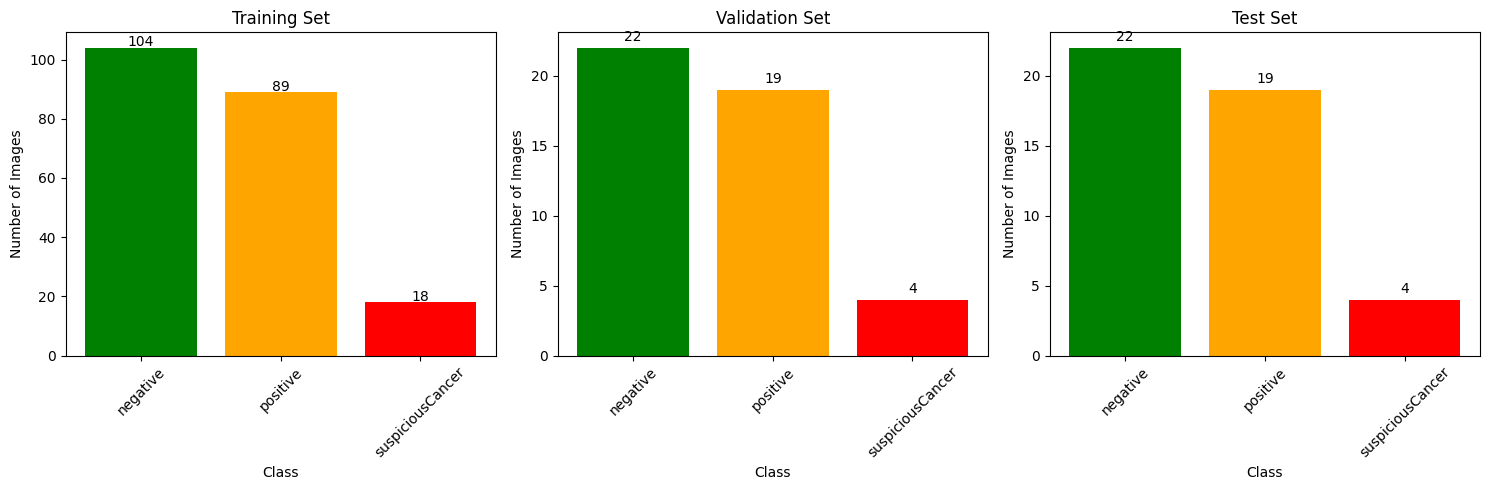


Dataset Summary:
--------------------------------------------------

Train Set (211 images):
  negative: 104 (49.3%)
  positive: 89 (42.2%)
  suspiciousCancer: 18 (8.5%)

Val Set (45 images):
  negative: 22 (48.9%)
  positive: 19 (42.2%)
  suspiciousCancer: 4 (8.9%)

Test Set (45 images):
  negative: 22 (48.9%)
  positive: 19 (42.2%)
  suspiciousCancer: 4 (8.9%)


In [5]:
# Calculate class distribution
from collections import Counter

def get_class_distribution(dataset):
    """Get the distribution of classes in the dataset"""
    labels = [dataset[i][1] for i in range(len(dataset))]
    return Counter(labels)

# Get distributions
train_dist = get_class_distribution(train_ds)
val_dist = get_class_distribution(val_ds)
test_dist = get_class_distribution(test_ds)

# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (dist, title) in zip(axes, [(train_dist, 'Training Set'),
                                     (val_dist, 'Validation Set'),
                                     (test_dist, 'Test Set')]):
    classes = list(train_ds.class_to_idx.keys())
    counts = [dist[train_ds.class_to_idx[c]] for c in classes]

    ax.bar(classes, counts, color=['green', 'orange', 'red'])
    ax.set_title(title)
    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Images')
    ax.set_xticklabels(classes, rotation=45)

    # Add count labels on bars
    for i, count in enumerate(counts):
        ax.text(i, count + 0.5, str(count), ha='center')

plt.tight_layout()
plt.show()

# Print summary
print("\nDataset Summary:")
print("-" * 50)
for split_name, dist in [('Train', train_dist), ('Val', val_dist), ('Test', test_dist)]:
    total = sum(dist.values())
    print(f"\n{split_name} Set ({total} images):")
    for class_name, class_idx in train_ds.class_to_idx.items():
        count = dist[class_idx]
        percentage = (count / total) * 100
        print(f"  {class_name}: {count} ({percentage:.1f}%)")

In [26]:
# BALANCED: Use proven EfficientNet-B3 with moderate capacity
import torchvision.models as models

class BalancedCervicalCNN(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.4):
        super(BalancedCervicalCNN, self).__init__()

        # Use EfficientNet-B3 - good balance between capacity and overfitting
        self.backbone = models.efficientnet_b3(pretrained=True)

        # Freeze first 50% of layers - balanced approach
        total_layers = len(list(self.backbone.parameters()))
        for idx, param in enumerate(self.backbone.parameters()):
            if idx < total_layers // 2:
                param.requires_grad = False

        # Get feature dimension
        num_features = self.backbone.classifier[1].in_features

        # Balanced classifier - not too deep
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate, inplace=True),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate * 0.6),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate * 0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = BalancedCervicalCNN(num_classes=3, dropout_rate=0.35).to(device)
print("✓ Balanced model (EfficientNet-B3) initialized successfully!")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using device: cuda
✓ Balanced model (EfficientNet-B3) initialized successfully!
Total parameters: 11,616,811
Trainable parameters: 10,743,569


In [27]:
# BALANCED: Simple and effective training with Mixup
def mixup_data(x, y, alpha=0.3):
    """Mixup data augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_epoch(model, dataloader, criterion, optimizer, device, use_mixup=True):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc='Training')
    for batch_idx, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device)

        # Apply mixup with 50% probability
        if use_mixup and np.random.rand() > 0.5:
            mixed_images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=0.3)
            optimizer.zero_grad()
            outputs = model(mixed_images)
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
        else:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if batch_idx % 3 == 0:
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc, all_predictions, all_labels

In [28]:
# IMPROVED: Slightly optimized training configuration
num_epochs = 60  # 40→45: train a bit longer
learning_rate = 0.0003  # 0.00025→0.0003: slightly higher
weight_decay = 6e-4  # 5e-4→6e-4: slightly stronger regularization

# Use weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
print(f"Using weighted CrossEntropyLoss with class weights: {class_weights}")

# Optimizer - AdamW
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Cosine annealing with warm restarts
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=15, T_mult=1, eta_min=1e-6
)

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("\n" + "="*60)
print("Starting Balanced Training")
print("="*60)
print(f"Model: EfficientNet-B3")
print(f"Epochs: {num_epochs}")
print(f"Learning Rate: {learning_rate}")
print(f"Target: Val Acc > 80%")
print("="*60)

best_val_acc = 0
best_epoch = 0
patience = 15
patience_counter = 0

# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 40)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, use_mixup=True)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # Validate
    val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Learning rate scheduling
    scheduler.step()

    # Save best model
    if val_acc > best_val_acc:
        improvement = val_acc - best_val_acc
        best_val_acc = val_acc
        best_epoch = epoch + 1
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'history': history
        }, os.path.join(DataPath, 'best_model_balanced.pth'))
        print(f"✓ NEW BEST! Improved by {improvement:.2f}%")
    else:
        patience_counter += 1

    # Print epoch results
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Best Val Acc: {best_val_acc:.2f}% (Epoch {best_epoch})")
    print(f"LR: {optimizer.param_groups[0]['lr']:.6f} | Patience: {patience_counter}/{patience}")

    # # Target progress
    # if best_val_acc >= 80.0:
    #     print(f"🎉 TARGET ACHIEVED: {best_val_acc:.2f}% >= 80%")
    #     print(f"Stopping training early!")
    #     break
    # else:
    #     gap = 80.0 - best_val_acc
    #     print(f"Progress: {best_val_acc:.2f}% / 80% (need +{gap:.2f}%)")

    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping after {patience} epochs without improvement")
        break

print("\n" + "="*60)
print("TRAINING COMPLETED")
print("="*60)
print(f"Best Validation Accuracy: {best_val_acc:.2f}% at epoch {best_epoch}")
print(f"Total epochs: {len(history['train_loss'])}")
print("="*60)

Using weighted CrossEntropyLoss with class weights: tensor([0.6763, 0.7903, 3.9074])

Starting Balanced Training
Model: EfficientNet-B3
Epochs: 60
Learning Rate: 0.0003
Target: Val Acc > 80%

Epoch 1/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


✓ NEW BEST! Improved by 26.67%
Train Loss: 1.1381 | Train Acc: 34.60%
Val Loss: 1.0856 | Val Acc: 26.67%
Best Val Acc: 26.67% (Epoch 1)
LR: 0.000297 | Patience: 0/15

Epoch 2/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


✓ NEW BEST! Improved by 2.22%
Train Loss: 0.9674 | Train Acc: 36.02%
Val Loss: 1.0618 | Val Acc: 28.89%
Best Val Acc: 28.89% (Epoch 2)
LR: 0.000287 | Patience: 0/15

Epoch 3/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]


✓ NEW BEST! Improved by 11.11%
Train Loss: 0.8076 | Train Acc: 54.98%
Val Loss: 0.9759 | Val Acc: 40.00%
Best Val Acc: 40.00% (Epoch 3)
LR: 0.000271 | Patience: 0/15

Epoch 4/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]


✓ NEW BEST! Improved by 8.89%
Train Loss: 0.7470 | Train Acc: 59.72%
Val Loss: 0.9332 | Val Acc: 48.89%
Best Val Acc: 48.89% (Epoch 4)
LR: 0.000251 | Patience: 0/15

Epoch 5/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


✓ NEW BEST! Improved by 6.67%
Train Loss: 0.6727 | Train Acc: 59.24%
Val Loss: 0.8720 | Val Acc: 55.56%
Best Val Acc: 55.56% (Epoch 5)
LR: 0.000225 | Patience: 0/15

Epoch 6/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


✓ NEW BEST! Improved by 2.22%
Train Loss: 0.5441 | Train Acc: 59.72%
Val Loss: 0.8232 | Val Acc: 57.78%
Best Val Acc: 57.78% (Epoch 6)
LR: 0.000197 | Patience: 0/15

Epoch 7/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]


Train Loss: 0.6032 | Train Acc: 71.56%
Val Loss: 0.8538 | Val Acc: 57.78%
Best Val Acc: 57.78% (Epoch 6)
LR: 0.000166 | Patience: 1/15

Epoch 8/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Train Loss: 0.5345 | Train Acc: 64.93%
Val Loss: 0.9213 | Val Acc: 48.89%
Best Val Acc: 57.78% (Epoch 6)
LR: 0.000135 | Patience: 2/15

Epoch 9/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


Train Loss: 0.4319 | Train Acc: 73.93%
Val Loss: 0.9331 | Val Acc: 42.22%
Best Val Acc: 57.78% (Epoch 6)
LR: 0.000104 | Patience: 3/15

Epoch 10/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]


Train Loss: 0.4036 | Train Acc: 81.52%
Val Loss: 0.8800 | Val Acc: 46.67%
Best Val Acc: 57.78% (Epoch 6)
LR: 0.000076 | Patience: 4/15

Epoch 11/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.95it/s]


Train Loss: 0.5231 | Train Acc: 66.82%
Val Loss: 0.9616 | Val Acc: 44.44%
Best Val Acc: 57.78% (Epoch 6)
LR: 0.000050 | Patience: 5/15

Epoch 12/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]


Train Loss: 0.4508 | Train Acc: 73.93%
Val Loss: 0.9461 | Val Acc: 46.67%
Best Val Acc: 57.78% (Epoch 6)
LR: 0.000030 | Patience: 6/15

Epoch 13/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]


Train Loss: 0.3597 | Train Acc: 80.57%
Val Loss: 0.9523 | Val Acc: 44.44%
Best Val Acc: 57.78% (Epoch 6)
LR: 0.000014 | Patience: 7/15

Epoch 14/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]


Train Loss: 0.3013 | Train Acc: 83.41%
Val Loss: 0.8650 | Val Acc: 55.56%
Best Val Acc: 57.78% (Epoch 6)
LR: 0.000004 | Patience: 8/15

Epoch 15/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]


Train Loss: 0.3624 | Train Acc: 68.72%
Val Loss: 0.8437 | Val Acc: 55.56%
Best Val Acc: 57.78% (Epoch 6)
LR: 0.000300 | Patience: 9/15

Epoch 16/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Train Loss: 0.4166 | Train Acc: 81.04%
Val Loss: 0.9648 | Val Acc: 53.33%
Best Val Acc: 57.78% (Epoch 6)
LR: 0.000297 | Patience: 10/15

Epoch 17/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]


Train Loss: 0.3611 | Train Acc: 79.15%
Val Loss: 0.8901 | Val Acc: 51.11%
Best Val Acc: 57.78% (Epoch 6)
LR: 0.000287 | Patience: 11/15

Epoch 18/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]


Train Loss: 0.3487 | Train Acc: 79.15%
Val Loss: 0.8737 | Val Acc: 55.56%
Best Val Acc: 57.78% (Epoch 6)
LR: 0.000271 | Patience: 12/15

Epoch 19/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]


✓ NEW BEST! Improved by 6.67%
Train Loss: 0.4577 | Train Acc: 65.88%
Val Loss: 0.8181 | Val Acc: 64.44%
Best Val Acc: 64.44% (Epoch 19)
LR: 0.000251 | Patience: 0/15

Epoch 20/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]


Train Loss: 0.3724 | Train Acc: 84.36%
Val Loss: 0.8531 | Val Acc: 60.00%
Best Val Acc: 64.44% (Epoch 19)
LR: 0.000225 | Patience: 1/15

Epoch 21/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]


Train Loss: 0.3075 | Train Acc: 75.36%
Val Loss: 0.8910 | Val Acc: 57.78%
Best Val Acc: 64.44% (Epoch 19)
LR: 0.000197 | Patience: 2/15

Epoch 22/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]


✓ NEW BEST! Improved by 6.67%
Train Loss: 0.2512 | Train Acc: 87.20%
Val Loss: 0.8033 | Val Acc: 71.11%
Best Val Acc: 71.11% (Epoch 22)
LR: 0.000166 | Patience: 0/15

Epoch 23/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]


Train Loss: 0.6634 | Train Acc: 81.52%
Val Loss: 0.8546 | Val Acc: 66.67%
Best Val Acc: 71.11% (Epoch 22)
LR: 0.000135 | Patience: 1/15

Epoch 24/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Train Loss: 0.3495 | Train Acc: 78.20%
Val Loss: 0.9082 | Val Acc: 55.56%
Best Val Acc: 71.11% (Epoch 22)
LR: 0.000104 | Patience: 2/15

Epoch 25/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.06it/s]


Train Loss: 0.3104 | Train Acc: 78.67%
Val Loss: 0.8667 | Val Acc: 62.22%
Best Val Acc: 71.11% (Epoch 22)
LR: 0.000076 | Patience: 3/15

Epoch 26/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


Train Loss: 0.3229 | Train Acc: 73.93%
Val Loss: 0.9039 | Val Acc: 57.78%
Best Val Acc: 71.11% (Epoch 22)
LR: 0.000050 | Patience: 4/15

Epoch 27/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]


Train Loss: 0.2765 | Train Acc: 71.56%
Val Loss: 0.8896 | Val Acc: 62.22%
Best Val Acc: 71.11% (Epoch 22)
LR: 0.000030 | Patience: 5/15

Epoch 28/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]


Train Loss: 0.1485 | Train Acc: 87.68%
Val Loss: 0.8580 | Val Acc: 64.44%
Best Val Acc: 71.11% (Epoch 22)
LR: 0.000014 | Patience: 6/15

Epoch 29/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]


Train Loss: 0.3537 | Train Acc: 80.09%
Val Loss: 0.8248 | Val Acc: 64.44%
Best Val Acc: 71.11% (Epoch 22)
LR: 0.000004 | Patience: 7/15

Epoch 30/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


Train Loss: 0.3345 | Train Acc: 95.73%
Val Loss: 0.8592 | Val Acc: 60.00%
Best Val Acc: 71.11% (Epoch 22)
LR: 0.000300 | Patience: 8/15

Epoch 31/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.95it/s]


Train Loss: 0.5261 | Train Acc: 62.09%
Val Loss: 0.8776 | Val Acc: 60.00%
Best Val Acc: 71.11% (Epoch 22)
LR: 0.000297 | Patience: 9/15

Epoch 32/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]


Train Loss: 0.2298 | Train Acc: 90.52%
Val Loss: 0.6845 | Val Acc: 68.89%
Best Val Acc: 71.11% (Epoch 22)
LR: 0.000287 | Patience: 10/15

Epoch 33/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Train Loss: 0.3954 | Train Acc: 82.46%
Val Loss: 0.7550 | Val Acc: 66.67%
Best Val Acc: 71.11% (Epoch 22)
LR: 0.000271 | Patience: 11/15

Epoch 34/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]


✓ NEW BEST! Improved by 8.89%
Train Loss: 0.2707 | Train Acc: 87.68%
Val Loss: 0.6325 | Val Acc: 80.00%
Best Val Acc: 80.00% (Epoch 34)
LR: 0.000251 | Patience: 0/15

Epoch 35/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]


Train Loss: 0.4715 | Train Acc: 89.57%
Val Loss: 0.7840 | Val Acc: 73.33%
Best Val Acc: 80.00% (Epoch 34)
LR: 0.000225 | Patience: 1/15

Epoch 36/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Train Loss: 0.3589 | Train Acc: 90.05%
Val Loss: 0.7873 | Val Acc: 75.56%
Best Val Acc: 80.00% (Epoch 34)
LR: 0.000197 | Patience: 2/15

Epoch 37/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]


Train Loss: 0.2877 | Train Acc: 77.25%
Val Loss: 0.8683 | Val Acc: 71.11%
Best Val Acc: 80.00% (Epoch 34)
LR: 0.000166 | Patience: 3/15

Epoch 38/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]


Train Loss: 0.2440 | Train Acc: 81.52%
Val Loss: 0.7932 | Val Acc: 75.56%
Best Val Acc: 80.00% (Epoch 34)
LR: 0.000135 | Patience: 4/15

Epoch 39/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


Train Loss: 0.2348 | Train Acc: 75.83%
Val Loss: 0.8212 | Val Acc: 66.67%
Best Val Acc: 80.00% (Epoch 34)
LR: 0.000104 | Patience: 5/15

Epoch 40/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Train Loss: 0.3989 | Train Acc: 76.78%
Val Loss: 0.8567 | Val Acc: 66.67%
Best Val Acc: 80.00% (Epoch 34)
LR: 0.000076 | Patience: 6/15

Epoch 41/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]


Train Loss: 0.5472 | Train Acc: 76.30%
Val Loss: 0.8610 | Val Acc: 66.67%
Best Val Acc: 80.00% (Epoch 34)
LR: 0.000050 | Patience: 7/15

Epoch 42/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]


Train Loss: 0.3861 | Train Acc: 89.10%
Val Loss: 0.8624 | Val Acc: 68.89%
Best Val Acc: 80.00% (Epoch 34)
LR: 0.000030 | Patience: 8/15

Epoch 43/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Train Loss: 0.3814 | Train Acc: 77.73%
Val Loss: 0.8721 | Val Acc: 66.67%
Best Val Acc: 80.00% (Epoch 34)
LR: 0.000014 | Patience: 9/15

Epoch 44/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.95it/s]


Train Loss: 0.2973 | Train Acc: 81.99%
Val Loss: 0.8851 | Val Acc: 66.67%
Best Val Acc: 80.00% (Epoch 34)
LR: 0.000004 | Patience: 10/15

Epoch 45/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


Train Loss: 0.2897 | Train Acc: 75.83%
Val Loss: 0.8448 | Val Acc: 66.67%
Best Val Acc: 80.00% (Epoch 34)
LR: 0.000300 | Patience: 11/15

Epoch 46/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]


Train Loss: 0.2601 | Train Acc: 85.78%
Val Loss: 0.8311 | Val Acc: 68.89%
Best Val Acc: 80.00% (Epoch 34)
LR: 0.000297 | Patience: 12/15

Epoch 47/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


Train Loss: 0.1593 | Train Acc: 80.57%
Val Loss: 0.7566 | Val Acc: 73.33%
Best Val Acc: 80.00% (Epoch 34)
LR: 0.000287 | Patience: 13/15

Epoch 48/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]


Train Loss: 0.2122 | Train Acc: 79.62%
Val Loss: 0.7515 | Val Acc: 73.33%
Best Val Acc: 80.00% (Epoch 34)
LR: 0.000271 | Patience: 14/15

Epoch 49/60
----------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]

Train Loss: 0.3550 | Train Acc: 82.94%
Val Loss: 0.7016 | Val Acc: 68.89%
Best Val Acc: 80.00% (Epoch 34)
LR: 0.000251 | Patience: 15/15

Early stopping after 15 epochs without improvement

TRAINING COMPLETED
Best Validation Accuracy: 80.00% at epoch 34
Total epochs: 49


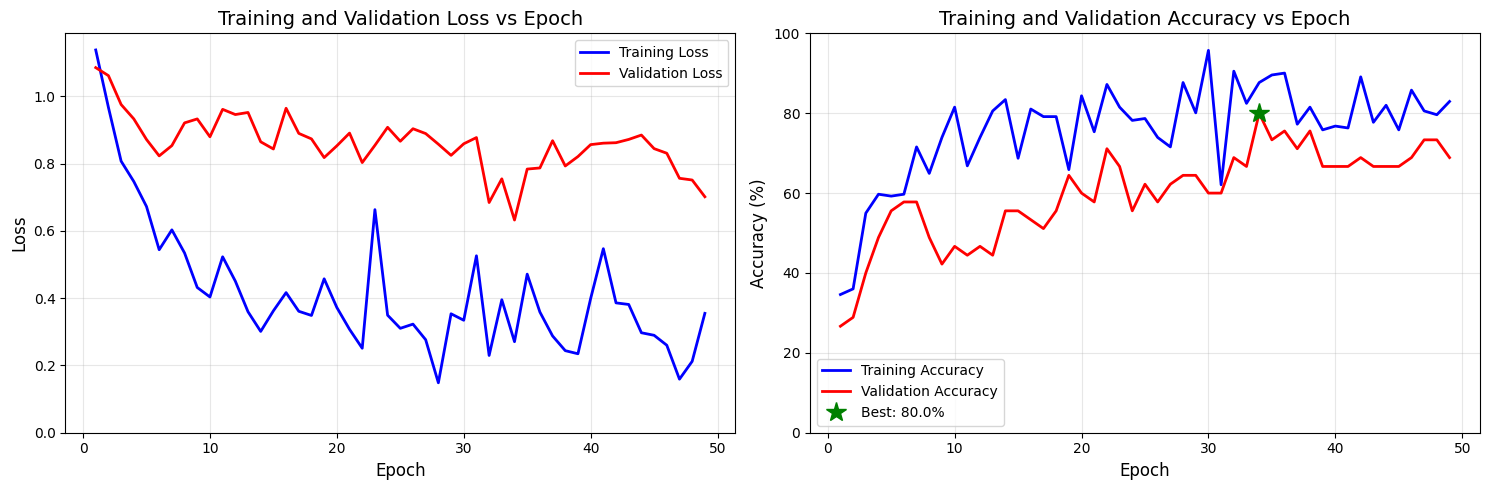


Training Summary:
--------------------------------------------------
Total epochs trained: 49
Best validation accuracy: 80.00% at epoch 34


In [29]:
# Plot training curves - REQUIRED FOR PROJECT UPDATE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Plot loss curves
ax1.plot(epochs_range, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
ax1.plot(epochs_range, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss vs Epoch', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(bottom=0)

# Plot accuracy curves
ax2.plot(epochs_range, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
ax2.plot(epochs_range, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy vs Epoch', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 100])

# Add best epoch marker
best_epoch_idx = history['val_acc'].index(max(history['val_acc']))
ax2.plot(best_epoch_idx + 1, history['val_acc'][best_epoch_idx], 'g*', markersize=15,
         label=f'Best: {max(history["val_acc"]):.1f}%')
ax2.legend()

plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(DataPath, 'training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print training summary
print("\nTraining Summary:")
print("-" * 50)
print(f"Total epochs trained: {len(history['train_loss'])}")
print(f"Best validation accuracy: {max(history['val_acc']):.2f}% at epoch {best_epoch_idx + 1}")
# print(f"Final training accuracy: {history['train_acc'][-1]:.2f}%")
# print(f"Final validation accuracy: {history['val_acc'][-1]:.2f}%")

# Task
Generate a demonstration of the trained model's classification capabilities. This involves:
1. Loading the best performing model (`best_model_balanced.pth`).
2. Creating a function to predict and visualize the class of a single image, showing the original image, predicted class, and confidence score.
3. Selecting 3-5 representative images from the test set.
4. Applying the prediction and visualization function to these selected images.
5. Providing instructions to the user on how to record and embed a demonstration video into a PPT presentation, highlighting the model's speed and accuracy.

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import os
import torch
import torch.nn as nn # Added for model definition
import torchvision.models as models # Added for model definition
from google.colab import drive

# Mount Google Drive to ensure access to DataPath
drive.mount('/content/drive')

# Re-define DataPath and device to ensure they are available in this cell's scope
DataPath = "/content/drive/MyDrive"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Re-define the model class (as it was in bDpbBmhuiBet) before instantiating the model
class BalancedCervicalCNN(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.4):
        super(BalancedCervicalCNN, self).__init__()

        self.backbone = models.efficientnet_b3(pretrained=True)

        total_layers = len(list(self.backbone.parameters()))
        for idx, param in enumerate(self.backbone.parameters()):
            if idx < total_layers // 2:
                param.requires_grad = False

        num_features = self.backbone.classifier[1].in_features

        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate, inplace=True),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate * 0.6),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate * 0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# Re-initialize model
model = BalancedCervicalCNN(num_classes=3, dropout_rate=0.35).to(device)

model_path = os.path.join(DataPath, 'best_model_balanced.pth')

# Load the entire checkpoint, including history
checkpoint = torch.load(model_path, map_location=device)

# Load the model's state_dict
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
model.eval()

print(f"✓ Loaded best model from {model_path}")
print(f"Model set to evaluation mode (model.eval())")
print(f"Best validation accuracy from loaded model: {checkpoint['val_acc']:.2f}%")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✓ Loaded best model from /content/drive/MyDrive/best_model_balanced.pth
Model set to evaluation mode (model.eval())
Best validation accuracy from loaded model: 80.00%


**Reasoning**:
Now that the best model is loaded, I need to create a function that takes an image path, preprocesses the image, makes a prediction using the loaded model, and then visualizes the image along with its predicted class and confidence. This function will be crucial for demonstrating the model's capabilities.



In [15]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch.nn.functional as F

def predict_and_visualize(model, image_path, transform, class_names, device):
    """Predicts the class of a single image and visualizes it with confidence."""
    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Preprocess the image
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)

    predicted_class = class_names[predicted_idx.item()]
    confidence_score = confidence.item() * 100

    # Visualize the result
    plt.figure(figsize=(6, 6))
    plt.imshow(np.array(image))
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence_score:.2f}%", fontsize=14)
    plt.axis('off')
    plt.show()

    print(f"Image: {image_path.split('/')[-1]}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence_score:.2f}%")
    return predicted_class, confidence_score

print("✓ `predict_and_visualize` function defined.")


✓ `predict_and_visualize` function defined.


In [16]:
import random
import os

# Re-define necessary imports and variables for datasets
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# DataPath should be available from previous cells, but re-defining for self-containment if notebook state resets.
# DataPath = "/content/drive/MyDrive" # Assuming DataPath is already defined or re-defined as in previous fix cells

# Re-define data transforms as they were in cell 3sPGFbzmhlN2
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(18),
    transforms.ColorJitter(brightness=0.35, contrast=0.35, saturation=0.25, hue=0.02),
    transforms.RandomResizedCrop((224, 224), scale=(0.82, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.08))
])

val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Re-load datasets as they were in cell 3sPGFbzmhlN2
train_ds = datasets.ImageFolder(DataPath + '/dataset_split/train', transform=train_transform)
val_ds   = datasets.ImageFolder(DataPath + '/dataset_split/val',   transform=val_test_transform)
test_ds  = datasets.ImageFolder(DataPath + '/dataset_split/test',  transform=val_test_transform)

# Get class names from the dataset
class_names = list(train_ds.class_to_idx.keys())
print(f"Class names: {class_names}")

# Select 3-5 representative images from the test set
# To ensure variety, let's try to pick one from each class if possible, plus a couple more.

selected_image_paths = []
num_images_to_show = 5 # Can adjust this

# Group test images by class for easier selection
class_image_paths = {class_name: [] for class_name in class_names}
for idx, (path, label) in enumerate(test_ds.imgs):
    class_name = test_ds.classes[label] # Corrected from class_ds to test_ds
    class_image_paths[class_name].append(path)

# Try to get at least one from each class
for class_name in class_names:
    if class_image_paths[class_name]:
        selected_image_paths.append(random.choice(class_image_paths[class_name]))

# If we still need more images, fill up with random choices
while len(selected_image_paths) < num_images_to_show and len(selected_image_paths) < len(test_ds):
    random_image_path = random.choice(test_ds.imgs)[0]
    if random_image_path not in selected_image_paths:
        selected_image_paths.append(random_image_path)

print(f"\nSelected {len(selected_image_paths)} images for demonstration:")
for i, path in enumerate(selected_image_paths):
    print(f"{i+1}. {os.path.basename(path)}")

Class names: ['negative', 'positive', 'suspiciousCancer']

Selected 5 images for demonstration:
1. 41.jpg
2. 121.jpg
3. 185.jpg
4. 142.jpg
5. 29.jpg



--- Demonstrating Model Predictions ---

Processing image 1/5:


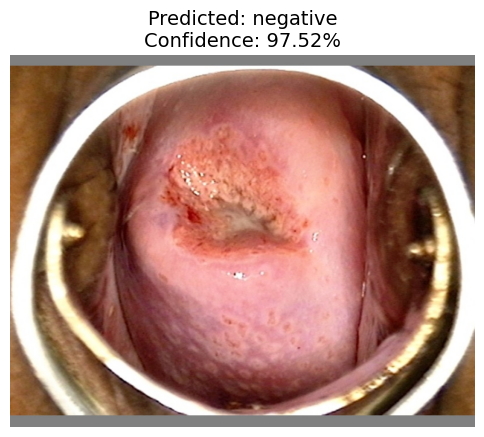

Image: 41.jpg
Predicted Class: negative
Confidence: 97.52%

Processing image 2/5:


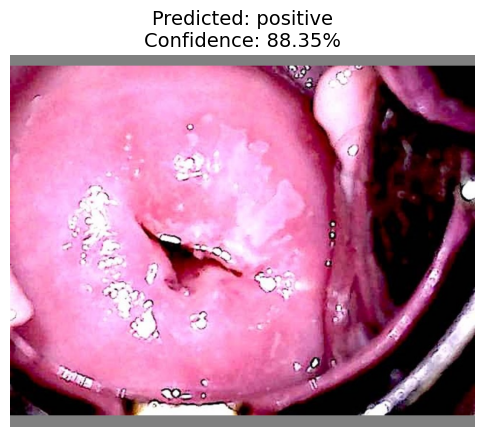

Image: 121.jpg
Predicted Class: positive
Confidence: 88.35%

Processing image 3/5:


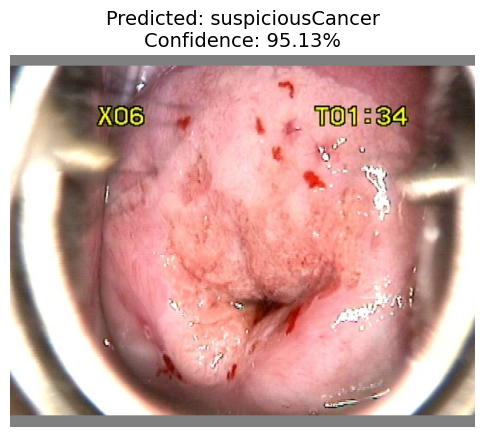

Image: 185.jpg
Predicted Class: suspiciousCancer
Confidence: 95.13%

Processing image 4/5:


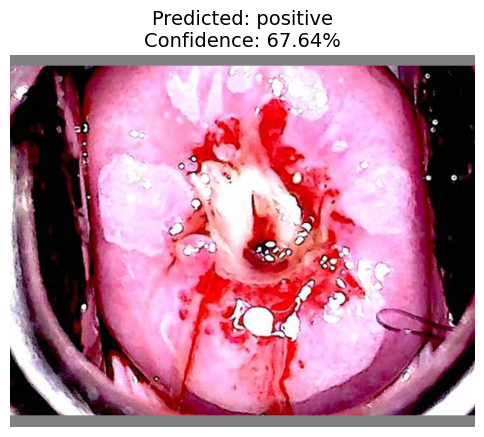

Image: 142.jpg
Predicted Class: positive
Confidence: 67.64%

Processing image 5/5:


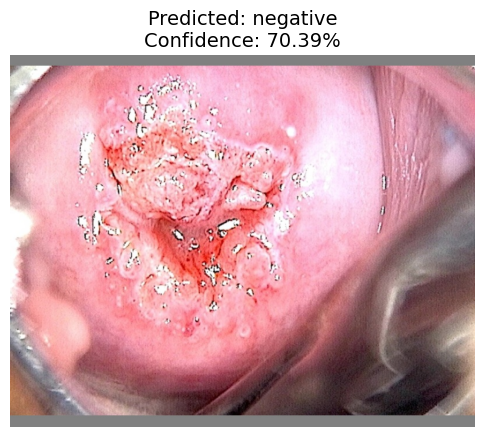

Image: 29.jpg
Predicted Class: negative
Confidence: 70.39%


In [17]:
print("\n--- Demonstrating Model Predictions ---")
for i, image_path in enumerate(selected_image_paths):
    print(f"\nProcessing image {i+1}/{len(selected_image_paths)}:")
    predicted_class, confidence_score = predict_and_visualize(model, image_path, val_test_transform, class_names, device)